# Snake Voice‑Command Classification

This notebook trains two different models (CNN and CRNN) on a spoken‑command dataset, selects the best performer on the validation split, and evaluates it on an unseen test split.

This work is inspired by the TensorFlow keyword‑spotting tutorial: [Keyword Spotting](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython import display

from models.cnn_model import build_cnn_model
from models.crnn_model import build_crnn_model

## Data Loading & Preprocessing

First we point to the folder of raw WAV files organized by command label. TensorFlow's `audio_dataset_from_directory` loads them into `train_ds` and `val_da`, enforcing a fixed length of 1 second (16 000 samples)

In [34]:
data_dir = "../data/snake_commands"
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Raw folders (commands):', commands)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print("\nLabel names:", label_names)

Raw folders (commands): ['right' 'left' 'up' 'down']
Found 9454 files belonging to 4 classes.
Using 7564 files for training.
Using 1890 files for validation.

Label names: ['down' 'left' 'right' 'up']


Each audio tensor comes in shape (`batch, 16000, 1`), so we `squeeze` out the last dimension. We also split half of our validation set into test set so we never tune on it.

In [35]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

## Audio & Spectrogram Visualization

Before modeling, it's helpful to look at some waveforms and their spectrograms. This gives ut intuition about the time-frequency patterns the model will learn

In [36]:
# Inspect shapes
for example_audio, example_labels in train_ds.take(1):
    print("Audio shape:", example_audio.shape)
    print("Labels shape:", example_labels.shape)

Audio shape: (64, 16000)
Labels shape: (64,)


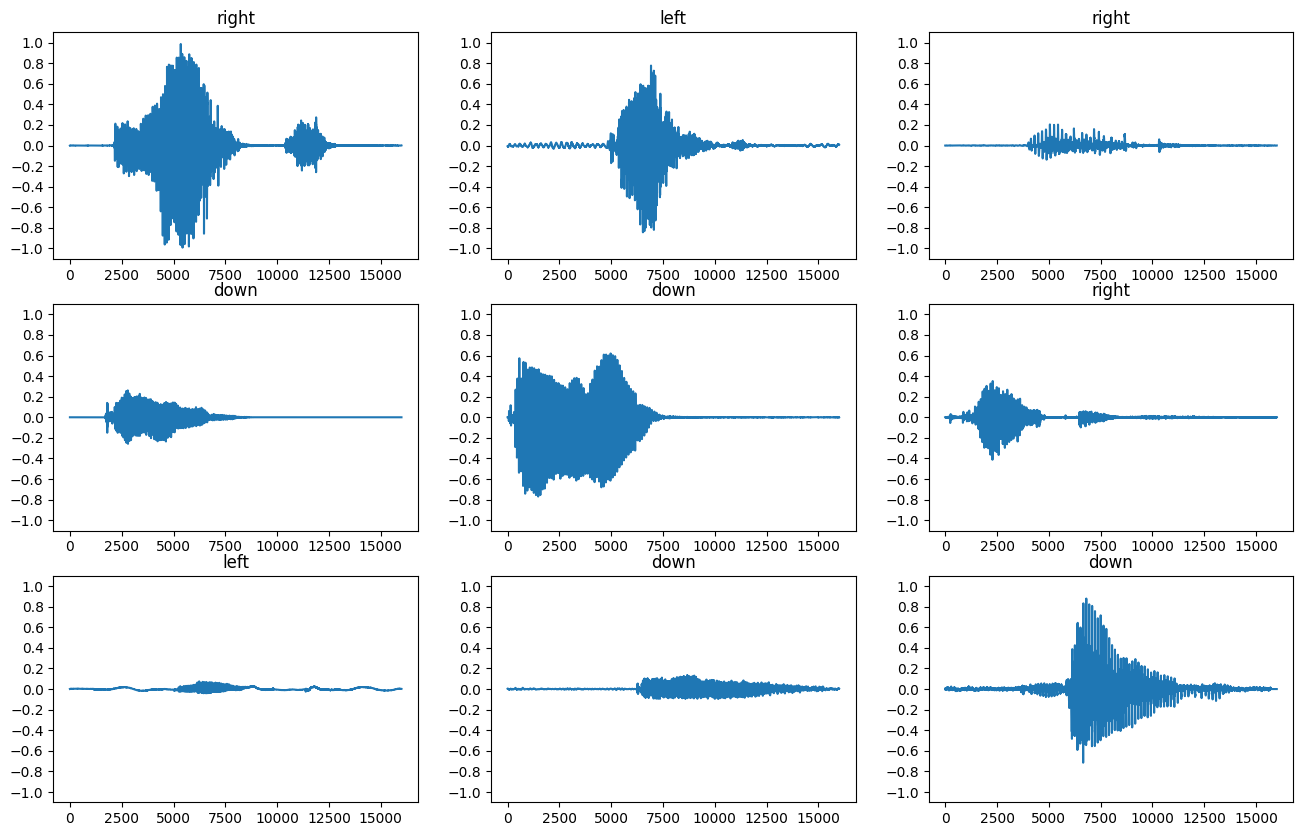

In [37]:
# Plot a few raw waveforms
plt.figure(figsize=(16, 10))
rows, cols = 3, 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(example_audio[i])
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.show()

In [38]:
# Spectrogram utilities
def get_spectogram(waveform):
    spectogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectogram = tf.abs(spectogram)[..., tf.newaxis]
    return spectogram

def plot_spectogram(spectogram, ax):
    if spectogram.ndim == 3:
        spectogram = np.squeeze(spectogram, axis=-1)
    log_spec = np.log(spectogram.T + np.finfo(float).eps)
    h, w = log_spec.shape
    X = np.linspace(0, np.size(spectogram), num=w, dtype=int)
    Y = range(h)
    ax.pcolormesh(X, Y, log_spec)

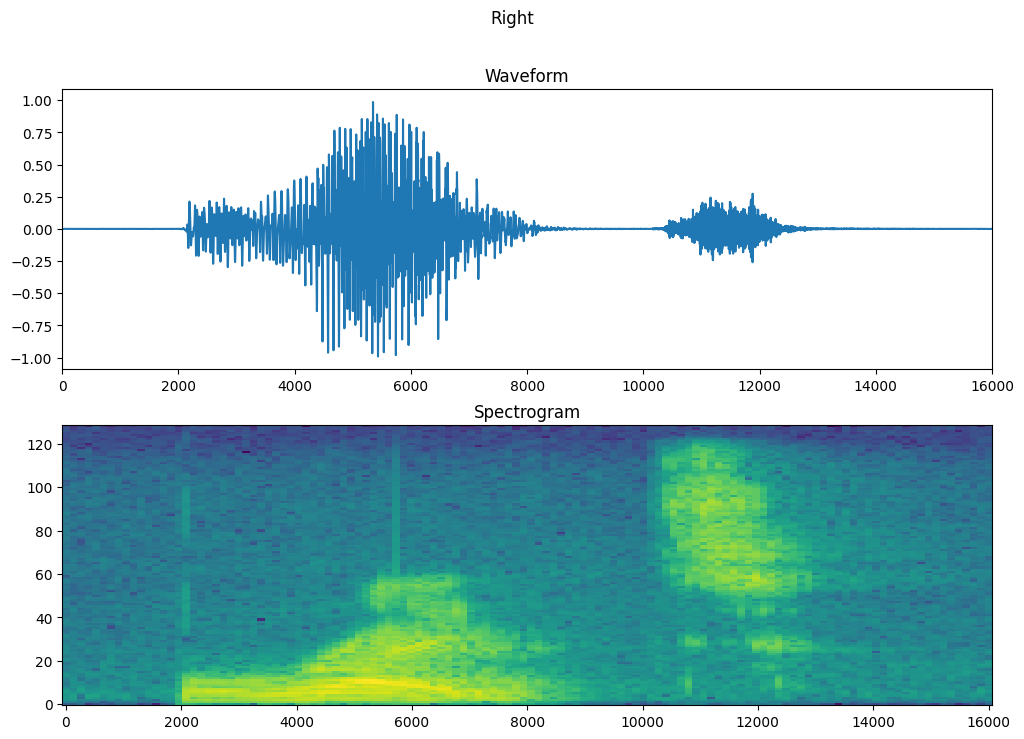

In [39]:
# Show waveform + spectrogram + play audio for one example
waveform = example_audio[0]
spectrogram = get_spectogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set(title='Waveform', xlim=[0, 16000])

plot_spectogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label_names[example_labels[0]].title())
plt.show()

display.display(display.Audio(waveform, rate=16000))


## Spectrogram Dataset Preparation

We now convert every raw audio to its spectrogram representation. Caching, shuffling, and prefetching are added to keep th GPU/CPU pipelines saturated without redundant disk reads.

In [40]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spec_ds = make_spec_ds(train_ds)
val_spec_ds   = make_spec_ds(val_ds)
test_spec_ds  = make_spec_ds(test_ds)

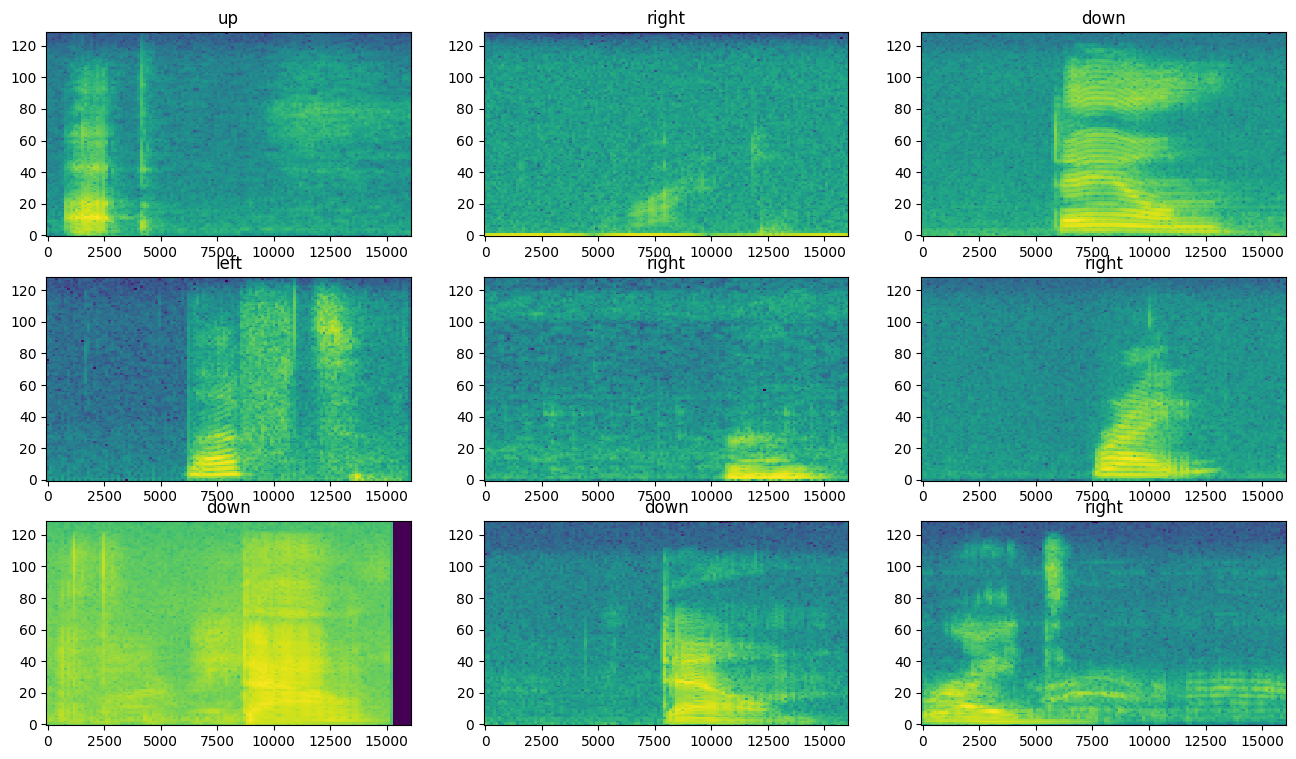

In [41]:
# Visual check of a few spectrgrams
for spec_batch, label_batch in train_spec_ds.take(1):
    example_specs = spec_batch.numpy()
    example_labs  = label_batch.numpy()
    break

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(rows*cols):
    r, c = divmod(i, cols)
    plot_spectogram(example_specs[i], axes[r][c])
    axes[r][c].set_title(label_names[example_labs[i]])
plt.show()

In [42]:
# Optimize input pipeline
train_spec_ds = train_spec_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spec_ds   = val_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spec_ds  = test_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model Building & Training

We examine one batch to get `input_shape` and numbers of labels, then create a `Normalization` layer to standardize the spectrogram amplitudes. Two models (CNN and CRNN) are built, compiled with sparse categorical cross-entropy, and trained with early stopping after 5 epochs of no improvment.

In [ ]:
# Determine input shape and setup normalization
for specs, _ in train_spec_ds.take(1):
    input_shape = specs.shape[1:]
num_labels = len(label_names)
print("Input shape:", input_shape, "\nNumber of classes:", num_labels)

norm_layer = layers.Normalization()
norm_layer.adapt(train_spec_ds.map(lambda spec, lab: spec))

Input shape: (124, 129, 1) 
Number of classes: 4


2025-04-19 20:44:35.040575: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Build models
models_dict = {
    'CNN':  build_cnn_model(input_shape, num_labels, norm_layer),
    'CRNN': build_crnn_model(input_shape, num_labels, norm_layer)
}

for name, m in models_dict.items():
    print(f"\n{'='*10} Summary for {name} {'='*10}\n")
    m.summary()

    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )


========== Summary for CNN ==========



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,096 (6.20 MB)

 Trainable params: 1,625,094 (6.20 MB)

 Non-trainable params: 2 (8.00 B)

In [45]:
# Train with early stopping
histories = {}
EPOCHS = 10
for name, m in models_dict.items():
    print(f"\n=== Training {name} ===")
    histories[name] = m.fit(
        train_spec_ds,
        validation_data=val_spec_ds,
        epochs=EPOCHS,
        callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)]
    )


=== Training CNN ===
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4997 - loss: 1.1511 - val_accuracy: 0.8409 - val_loss: 0.5168
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8552 - loss: 0.4466 - val_accuracy: 0.9054 - val_loss: 0.3207
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9015 - loss: 0.2777 - val_accuracy: 0.9387 - val_loss: 0.2108
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9275 - loss: 0.2103 - val_accuracy: 0.9473 - val_loss: 0.1906
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1810 - val_accuracy: 0.9441 - val_loss: 0.1790
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9501 - loss: 0.1437 - val_accuracy: 0.9570 - val_loss: 0.1617
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9572 - loss: 0.1236 - val_accuracy: 0.9484 - val_loss: 0.1691
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9576 - l

After training, we pick the model with the highest validation accuracy

In [46]:
best_name = max(
    histories,
    key=lambda n: max(histories[n].history['val_accuracy'])
)
best_model = models_dict[best_name]
print(f"Best model on the validation set: {best_name}")

Best model on the validation set: CNN


## Evaluation & Results

Finally, we evaluate the chosen model on out hold-out test set, save it, and plot metrics over epochs as well as a confusion matrix to see where the model confuses similar commands.

In [47]:
# Test evaluation and saving
print("=== Evaluating on the test set ===")
results = best_model.evaluate(test_spec_ds, return_dict=True)
print(f"Test results for {best_name}:", results)

best_model.save("best_voice_model.keras")
print(f"\nSaved the {best_name} model as 'best_voice_model.keras'")

=== Evaluating on the test set ===
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9599 - loss: 0.1597
Test results for CNN: {'accuracy': 0.956250011920929, 'loss': 0.17532865703105927}

Saved the CNN model as 'best_voice_model.keras'


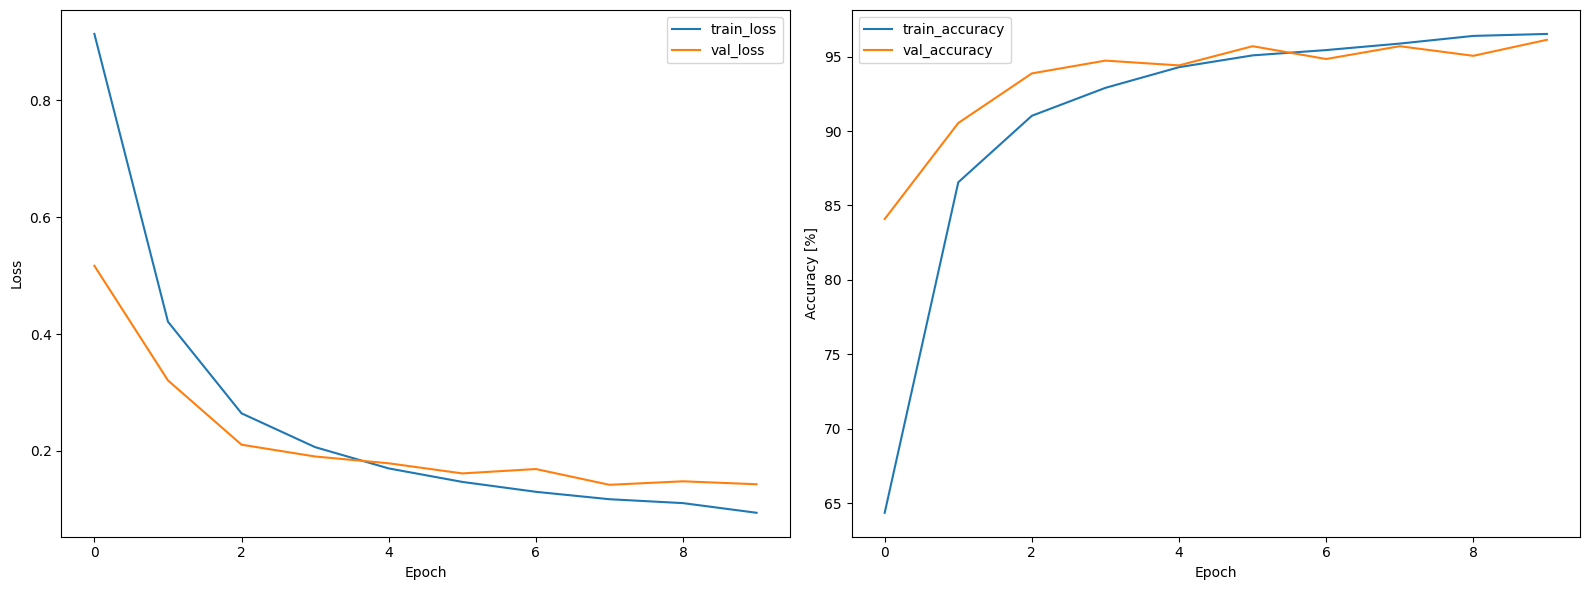

In [48]:
# Plot loss & accuracy curves
hist = histories[best_name].history

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(hist['loss'],      label='train_loss')
plt.plot(hist['val_loss'],  label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.array(hist['accuracy'])*100,     label='train_accuracy')
plt.plot(np.array(hist['val_accuracy'])*100, label='val_accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy [%]')
plt.legend()

plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


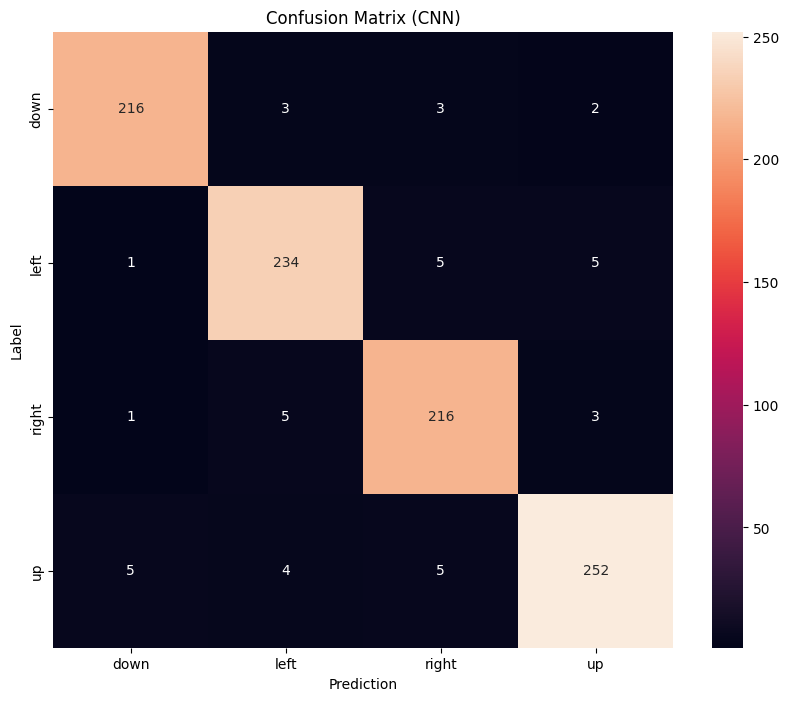

In [49]:
# Confusion matrix
y_pred = best_model.predict(test_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat([l for _, l in test_spec_ds.map(lambda s, l: (s, l))], axis=0)

cm = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction'); plt.ylabel('Label')
plt.title(f'Confusion Matrix ({best_name})')
plt.show()
